In [10]:
import pandas as pd
import numpy as np
import argparse
import itertools
import matplotlib.pyplot as plt

import re
import os
from os import path
import sys
import time

In [2]:
ms= {
    'EbbRT-Node1': 'v',
    'Linux-Node1': 'x',
    'Linux-Node2': '*',
    'Linux-Node3': 'o',
}

df_dict = {
    'qps': [],
    'i' : [],
    'ins': [],
    'cyc': [],
    'refcyc': [],
    'joules': [],
    'tail': [],
}

def resetdict():
    for key in df_dict:
        df_dict[key] = []

def parseLat(s):
    with open(s) as file:
        for line in file:
            if 'read' in line:
                return float((line.strip().split())[9])

## EbbRT C220G1

In [3]:
qps=0
i=0
with open("c220g1/silo/results.md") as file:
    for line in file:        
        ins=0
        cyc=0
        refcyc=0
        joules=0.0
        if "MQPS" in line.strip():
            qps = int(line.strip().split(' ')[2])
            i = 0
        elif "[STATS ALL]" in line.strip():            
            tmp = line.strip().split(' ')
            #print(tmp)
            ins = int(tmp[2])
            cyc = int(tmp[3])
            refcyc = int(tmp[4])
            joules = float(tmp[5])

            df_dict['qps'].append(qps)
            df_dict['i'].append(i)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(parseLat(f"c220g1/silo/ebbrtbm_silo_qps{qps}_iter{i}.out"))
            i += 1
df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dfebbrt = df.groupby(['qps']).mean()
dfebbrt['type'] = type
dfebbrt['ipc'] = dfebbrt['ins']/dfebbrt['refcyc']
dfebbrt=dfebbrt.drop(columns=['i'])
dfebbrt['qps'] = qpss
dfebbrt['kqps']=[int(x / 1000) for x in qpss]
dfebbrt['type']='EbbRT-Node1'
dfebbrt['watts'] = dfebbrt['joules']/30.0
dfebbrt['rpj'] = dfebbrt['qps']/dfebbrt['watts']
print(dfebbrt)

dfebbrtstd = df.groupby(['qps']).std()
dfebbrtstd['qps']=qpss
maxerr=0.0
for mqps in range(100000, 500000, 100000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dfebbrt[(dfebbrt['qps'] == mqps)][metric]), 2)
        stdm=round(float(dfebbrtstd[(dfebbrtstd['qps'] == mqps)][metric]),2)
        #print(mqps, metric, meanm, stdm, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dfebbrt was {maxerr}% of mean")

                 ins           cyc        refcyc       joules         tail  \
qps                                                                          
100000  2.260118e+11  2.033328e+11  1.991939e+11  1802.183333   200.766667   
200000  4.506124e+11  3.954283e+11  3.797036e+11  2009.243333   241.800000   
300000  6.757110e+11  5.847277e+11  5.608119e+11  2259.073333   302.800000   
400000  9.009332e+11  7.680198e+11  7.365544e+11  2451.133333   431.000000   
500000  1.125656e+12  9.458028e+11  9.070435e+11  2642.900000  1067.300000   

               type       ipc     qps  kqps      watts          rpj  
qps                                                                  
100000  EbbRT-Node1  1.134632  100000   100  60.072778  1664.647511  
200000  EbbRT-Node1  1.186748  200000   200  66.974778  2986.198785  
300000  EbbRT-Node1  1.204880  300000   300  75.302444  3983.934416  
400000  EbbRT-Node1  1.223173  400000   400  81.704444  4895.694509  
500000  EbbRT-Node1  1.241017  50

/tmp/ipykernel_6660/189383046.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  meanm=round(float(dfebbrt[(dfebbrt['qps'] == mqps)][metric]), 2)
/tmp/ipykernel_6660/189383046.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stdm=round(float(dfebbrtstd[(dfebbrtstd['qps'] == mqps)][metric]),2)


## Linux C220G1

In [4]:
## Overheads
resetdict()
ins_oh_arr=[]
cyc_oh_arr=[]
refcyc_oh_arr=[]
joules_oh_arr=[]

ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
for i in range (0, 4):    
    with open(f"c220g1/linux_silo/PerfStat.Ins.Overhead.linux_silo_iter{i}") as file:
        for line in file:      
            if 'instructions' in line:
                ins_oh_arr.append(int((line.strip().split(','))[0]))
            elif "ref-cycles" in line:
                refcyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'cycles' in line:
                cyc_oh_arr.append(int((line.strip().split(','))[0]))
    with open(f"c220g1/linux_silo/PerfStat.Joules.Overhead.linux_silo_iter{i}") as file:
        for line in file:
            if 'Joules' in line:
                joules_oh_arr.append(float((line.strip().split(','))[0]))
ins_oh = np.mean(ins_oh_arr)
cyc_oh = np.mean(cyc_oh_arr)
refcyc_oh = np.mean(refcyc_oh_arr)
joules_oh = np.mean(joules_oh_arr)
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
for mqps in range(100000, 500000, 100000):
    for iter in range(0, 5):
        if os.path.exists(f"c220g1/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") and os.path.exists(f"c220g1/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}"):
            ins=0
            cyc=0
            refcyc=0
            joules=0.0
            with open(f"c220g1/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file:  
                    if 'instructions' in line:
                        ins = int((line.strip().split(','))[0]) - ins_oh
                    elif "ref-cycles" in line:
                        refcyc = int((line.strip().split(','))[0]) - cyc_oh
                    elif 'cycles' in line:
                        cyc = int((line.strip().split(','))[0]) - refcyc_oh
            with open(f"c220g1/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file: 
                    if 'Joules' in line:
                        joules = float((line.strip().split(','))[0]) - joules_oh
            tail = parseLat(f"c220g1/linux_silo/linux_silo_mqps{mqps}_iter{iter}.out")
            df_dict['qps'].append(mqps)
            df_dict['i'].append(iter)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(tail)

df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dflinux_c220g1 = df.groupby(['qps']).mean()
dflinux_c220g1['ipc'] = dflinux_c220g1['ins']/dflinux_c220g1['refcyc']
dflinux_c220g1=dflinux_c220g1.drop(columns=['i'])
dflinux_c220g1['qps'] = qpss
dflinux_c220g1['kqps']=[int(x / 1000) for x in qpss]
dflinux_c220g1['type']='Linux-Node1'
dflinux_c220g1['watts'] = dflinux_c220g1['joules']/30.0
dflinux_c220g1['rpj'] = dflinux_c220g1['qps']/dflinux_c220g1['watts']
print(dflinux_c220g1)

dflinux_c220g1std = df.groupby(['qps']).std()
dflinux_c220g1std['qps']=qpss
maxerr=0.0
for mqps in range(100000, 400000, 100000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dflinux_c220g1[(dflinux_c220g1['qps'] == mqps)][metric]), 2)
        stdm=round(float(dflinux_c220g1std[(dflinux_c220g1std['qps'] == mqps)][metric]),2)
        #print(mqps, metric, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dflinux_c220g1 was {maxerr}% of mean")


176170693774.0 128721866509.0 97777050066.0 1430.04
                 ins           cyc        refcyc     joules       tail  \
qps                                                                      
100000  2.908164e+11  5.726933e+11  4.657972e+11  2007.8700    295.625   
200000  5.478447e+11  1.006666e+12  8.698660e+11  2429.6475    370.475   
300000  7.919115e+11  1.461441e+12  1.288450e+12  2725.0800    712.775   
400000  1.014208e+12  1.878810e+12  1.673696e+12  2954.2800  13758.000   

             ipc     qps  kqps         type     watts          rpj  
qps                                                                 
100000  0.624341  100000   100  Linux-Node1  66.92900  1494.120635  
200000  0.629804  200000   200  Linux-Node1  80.98825  2469.494032  
300000  0.614623  300000   300  Linux-Node1  90.83600  3302.655335  
400000  0.605969  400000   400  Linux-Node1  98.47600  4061.903408  
Largest error in dflinux_c220g1 was 1.09% of mean


/tmp/ipykernel_6660/257087371.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  meanm=round(float(dflinux_c220g1[(dflinux_c220g1['qps'] == mqps)][metric]), 2)
/tmp/ipykernel_6660/257087371.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stdm=round(float(dflinux_c220g1std[(dflinux_c220g1std['qps'] == mqps)][metric]),2)


## Linux C220G5

In [5]:
## Overheads
resetdict()
ins_oh_arr=[]
cyc_oh_arr=[]
refcyc_oh_arr=[]
joules_oh_arr=[]

ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
for i in range (0, 2):    
    with open(f"c220g5/linux_silo/PerfStat.Ins.Overhead.linux_silo_iter{i}") as file:
        for line in file:      
            if 'instructions' in line:
                ins_oh_arr.append(int((line.strip().split(','))[0]))
            elif "ref-cycles" in line:
                refcyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'cycles' in line:
                cyc_oh_arr.append(int((line.strip().split(','))[0]))
    with open(f"c220g5/linux_silo/PerfStat.Joules.Overhead.linux_silo_iter{i}") as file:
        for line in file:
            if 'Joules' in line:
                joules_oh_arr.append(float((line.strip().split(','))[0]))
ins_oh = np.mean(ins_oh_arr)
cyc_oh = np.mean(cyc_oh_arr)
refcyc_oh = np.mean(refcyc_oh_arr)
joules_oh = np.mean(joules_oh_arr)
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
for mqps in range(100000, 500000, 100000):
    for iter in range(0, 5):
        if os.path.exists(f"c220g5/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") and os.path.exists(f"c220g5/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}"):
            ins=0
            cyc=0
            refcyc=0
            joules=0.0
            with open(f"c220g5/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file:  
                    if 'instructions' in line:
                        ins = int((line.strip().split(','))[0]) - ins_oh
                    elif "ref-cycles" in line:
                        refcyc = int((line.strip().split(','))[0]) - cyc_oh
                    elif 'cycles' in line:
                        cyc = int((line.strip().split(','))[0]) - refcyc_oh
            with open(f"c220g5/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file: 
                    if 'Joules' in line:
                        joules = float((line.strip().split(','))[0]) - joules_oh
            tail = parseLat(f"c220g5/linux_silo/linux_silo_mqps{mqps}_iter{iter}.out")
            df_dict['qps'].append(mqps)
            df_dict['i'].append(iter)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(tail)

df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dflinux_c220g5 = df.groupby(['qps']).mean()
dflinux_c220g5['ipc'] = dflinux_c220g5['ins']/dflinux_c220g5['refcyc']
dflinux_c220g5=dflinux_c220g5.drop(columns=['i'])
dflinux_c220g5['qps'] = qpss
dflinux_c220g5['kqps']=[int(x / 1000) for x in qpss]
dflinux_c220g5['type']='Linux-Node2'
dflinux_c220g5['watts'] = dflinux_c220g5['joules']/30.0
dflinux_c220g5['rpj'] = dflinux_c220g5['qps']/dflinux_c220g5['watts']
print(dflinux_c220g5)

dflinux_c220g5std = df.groupby(['qps']).std()
dflinux_c220g5std['qps']=qpss
maxerr=0.0
for mqps in range(100000, 400000, 100000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dflinux_c220g5[(dflinux_c220g5['qps'] == mqps)][metric]), 2)
        stdm=round(float(dflinux_c220g5std[(dflinux_c220g5std['qps'] == mqps)][metric]),2)
        #print(mqps, metric, meanm, stdm, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dflinux_c220g5 was {maxerr}% of mean")


222628275024.5 408425549681.5 359598701616.0 8854.05
                 ins           cyc        refcyc    joules     tail       ipc  \
qps                                                                             
100000  2.908098e+11  5.628346e+11  4.045625e+11  2697.335   297.65  0.718826   
200000  5.490699e+11  1.039135e+12  8.227019e+11  3064.155   383.80  0.667398   
300000  7.914593e+11  1.499348e+12  1.227726e+12  3388.390   585.80  0.644655   
400000  0.000000e+00  0.000000e+00  0.000000e+00  3624.300  2845.90       NaN   

           qps  kqps         type       watts          rpj  
qps                                                         
100000  100000   100  Linux-Node2   89.911167  1112.208902  
200000  200000   200  Linux-Node2  102.138500  1958.125486  
300000  300000   300  Linux-Node2  112.946333  2656.128722  
400000  400000   400  Linux-Node2  120.810000  3310.984190  
Largest error in dflinux_c220g5 was 0.95% of mean


/tmp/ipykernel_6660/1999495674.py:76: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  meanm=round(float(dflinux_c220g5[(dflinux_c220g5['qps'] == mqps)][metric]), 2)
/tmp/ipykernel_6660/1999495674.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stdm=round(float(dflinux_c220g5std[(dflinux_c220g5std['qps'] == mqps)][metric]),2)


## Linux sm220u

In [6]:
## Overheads
resetdict()
ins_oh_arr=[]
cyc_oh_arr=[]
refcyc_oh_arr=[]
joules_oh_arr=[]

ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0
for i in range (0, 2):    
    with open(f"sm220u/linux_silo/PerfStat.Ins.Overhead.linux_silo_iter{i}") as file:
        for line in file:      
            if 'instructions' in line:
                ins_oh_arr.append(int((line.strip().split(','))[0]))
            elif "ref-cycles" in line:
                refcyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'cycles' in line:
                cyc_oh_arr.append(int((line.strip().split(','))[0]))
    with open(f"sm220u/linux_silo/PerfStat.Joules.Overhead.linux_silo_iter{i}") as file:
        for line in file:
            if 'Joules' in line:
                joules_oh_arr.append(float((line.strip().split(','))[0]))
ins_oh = np.mean(ins_oh_arr)
cyc_oh = np.mean(cyc_oh_arr)
refcyc_oh = np.mean(refcyc_oh_arr)
joules_oh = np.mean(joules_oh_arr)
            
print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
for mqps in range(100000, 1000000, 100000):
    for iter in range(0, 5):
        if os.path.exists(f"sm220u/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") and os.path.exists(f"sm220u/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}"):
            ins=0
            cyc=0
            refcyc=0
            joules=0.0
            with open(f"sm220u/linux_silo/PerfStat.Ins.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file:  
                    if 'instructions' in line:
                        ins = int((line.strip().split(','))[0]) - ins_oh
                    elif "ref-cycles" in line:
                        refcyc = int((line.strip().split(','))[0]) - cyc_oh
                    elif 'cycles' in line:
                        cyc = int((line.strip().split(','))[0]) - refcyc_oh
            with open(f"sm220u/linux_silo/PerfStat.Joules.linux_silo_mqps{mqps}_iter{iter}") as file:
                for line in file: 
                    if 'Joules' in line:
                        joules = float((line.strip().split(','))[0]) - joules_oh
            tail = parseLat(f"sm220u/linux_silo/linux_silo_mqps{mqps}_iter{iter}.out")
            df_dict['qps'].append(mqps)
            df_dict['i'].append(iter)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(tail)

df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dflinux_sm220u = df.groupby(['qps']).mean()
dflinux_sm220u['ipc'] = dflinux_sm220u['ins']/dflinux_sm220u['refcyc']
dflinux_sm220u=dflinux_sm220u.drop(columns=['i'])
dflinux_sm220u['qps'] = qpss
dflinux_sm220u['kqps']=[int(x / 1000) for x in qpss]
dflinux_sm220u['type']='Linux-Node3'
dflinux_sm220u['watts'] = dflinux_sm220u['joules']/30.0
dflinux_sm220u['rpj'] = dflinux_sm220u['qps']/dflinux_sm220u['watts']
print(dflinux_sm220u)

dflinux_sm220ustd = df.groupby(['qps']).std()
dflinux_sm220ustd['qps']=qpss
maxerr=0.0
print("")
for mqps in range(100000, 900000, 100000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        #print(dflinux_sm220u[(dflinux_sm220u['qps'] == mqps)])
        
        meanm=round(float(dflinux_sm220u[(dflinux_sm220u['qps'] == mqps)][metric]), 2)
        stdm=round(float(dflinux_sm220ustd[(dflinux_sm220ustd['qps'] == mqps)][metric]),2)
        #print(mqps, metric, meanm, stdm, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dflinux_sm220utd was {maxerr}% of mean")


356353880709.5 235275397312.5 166327981392.0 7498.01
                 ins           cyc        refcyc       joules         tail  \
qps                                                                          
100000  3.125580e+11  5.166675e+11  2.994718e+11  5612.455000   199.750000   
200000  6.049396e+11  9.316135e+11  6.404469e+11  6038.150000   213.750000   
300000  8.864342e+11  1.334926e+12  9.786166e+11  6421.320000   250.350000   
400000  1.157557e+12  1.717683e+12  1.295515e+12  6798.975000   274.300000   
500000  1.421570e+12  2.094551e+12  1.606779e+12  7723.240000   295.566667   
600000  1.676137e+12  2.466416e+12  1.914524e+12  8079.726667   368.066667   
700000  1.921867e+12  2.829724e+12  2.215803e+12  8365.896667   503.200000   
800000  2.158744e+12  3.183818e+12  2.508580e+12  8594.013333  1745.800000   

             ipc     qps  kqps         type       watts          rpj  
qps                                                                   
100000  1.043697  100000

/tmp/ipykernel_6660/3342916664.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  meanm=round(float(dflinux_sm220u[(dflinux_sm220u['qps'] == mqps)][metric]), 2)
/tmp/ipykernel_6660/3342916664.py:80: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stdm=round(float(dflinux_sm220ustd[(dflinux_sm220ustd['qps'] == mqps)][metric]),2)


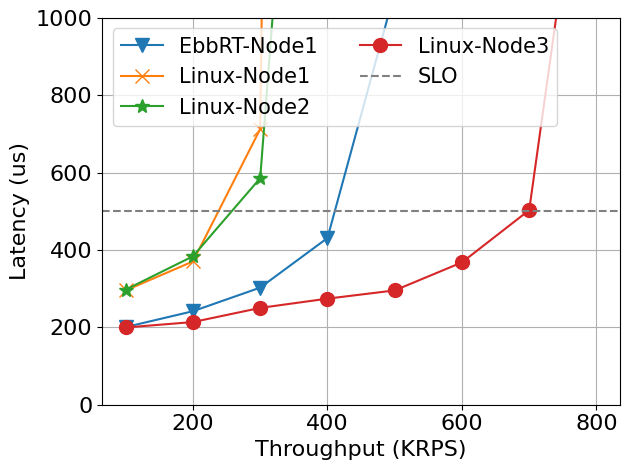

In [9]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

# Plot 99 tail
for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    plt.plot(df['kqps'].values, df['tail'].values, marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.axhline(y = 500, color = 'grey', linestyle = '--', label='SLO') 
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Latency (us)", fontsize=fs)
plt.ylim(bottom=0, top=1000)
plt.grid()
plt.legend(ncol=2, fontsize=15, loc="upper left")
plt.tight_layout()
plt.savefig("silo_latency.pdf")
#plt.show()


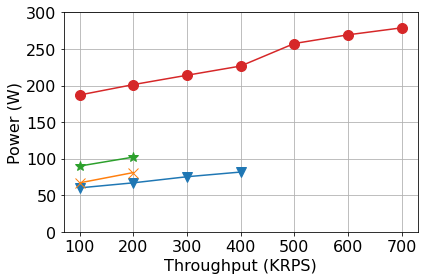

In [16]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    plt.plot(df['kqps'][:-1].values, df['watts'][:-1].values, marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Power (W)", fontsize=fs)
plt.ylim(bottom=0, top=300)
plt.grid()
#plt.legend(ncols=1, fontsize=fs, loc='lower right')
plt.tight_layout()
plt.savefig("silo_joules.pdf")

#plt.show()

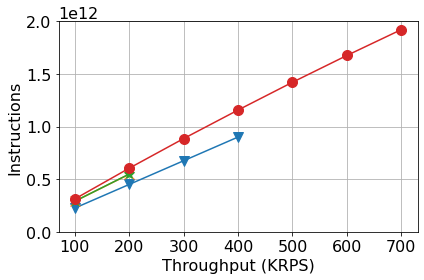

In [17]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    plt.plot(df['kqps'][:-1].values, df['ins'][:-1].values, marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Instructions", fontsize=fs)
plt.ylim(bottom=0, top=2000000000000)
plt.grid()
#plt.legend(ncols=1, fontsize=fs)
plt.tight_layout()
plt.savefig("silo_instructions.pdf")


In [18]:
for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    print(df['type'].unique())
    print(df[['ins', 'watts', 'rpj', 'tail']])
    print('*****************************')
    print("")

['EbbRT-Node1']
                 ins      watts          rpj         tail
qps                                                      
100000  2.260118e+11  60.072778  1664.647511   200.766667
200000  4.506124e+11  66.974778  2986.198785   241.800000
300000  6.757110e+11  75.302444  3983.934416   302.800000
400000  9.009332e+11  81.704444  4895.694509   431.000000
500000  1.125656e+12  88.096667  5675.583639  1067.300000
*****************************

['Linux-Node1']
                 ins     watts          rpj     tail
qps                                                 
100000  2.908164e+11  66.92900  1494.120635  295.625
200000  5.478447e+11  80.98825  2469.494032  370.475
300000  7.919115e+11  90.83600  3302.655335  712.775
*****************************

['Linux-Node2']
                 ins       watts          rpj    tail
qps                                                  
100000  2.908098e+11   89.911167  1112.208902  297.65
200000  5.490699e+11  102.138500  1958.125486  383.80
300

In [11]:
for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    ndf = df[df['tail'] < 500.0]
    print(ndf[['type', 'qps', 'watts', 'tail']])
    print('*****************************')
    print("")

               type     qps      watts        tail
qps                                               
100000  EbbRT-Node1  100000  60.072778  200.766667
200000  EbbRT-Node1  200000  66.974778  241.800000
300000  EbbRT-Node1  300000  75.302444  302.800000
400000  EbbRT-Node1  400000  81.704444  431.000000
*****************************

               type     qps     watts     tail
qps                                           
100000  Linux-Node1  100000  66.92900  295.625
200000  Linux-Node1  200000  80.98825  370.475
*****************************

               type     qps       watts    tail
qps                                            
100000  Linux-Node2  100000   89.911167  297.65
200000  Linux-Node2  200000  102.138500  383.80
*****************************

               type     qps       watts        tail
qps                                                
100000  Linux-Node3  100000  187.081833  199.750000
200000  Linux-Node3  200000  201.271667  213.750000
300000  Linux

In [12]:
# --- SILO -- numbers used for the following analysis @ peak load
# L-node1 : 200 KQPS,  80.99 Watts, 118.4 kg CO2 
# L-node2: 200 KQPS, 102.14 Watts, 152.9 kg CO2
# L-node3: 600 KQPS, 269.32 Watts, 221.9 kg CO2
# E-node1: 400 KQPS,  81.70 Watts, 118.4 kg CO2 

In [20]:
# L-node1
CM = 0
CI = 277300/998280000.0 # mg CO2/J
CC = CI * 81.70
CN = CI * (1250000000) * 2.7
ops = 200000
print(f"L-node1 CCI = {round((CM + (CC+CN))/ops, 2)} mg CO2/Request")

L-node1 CCI = 4.69 mg CO2/Request


In [18]:
# L-node2
CM = 152900
CI = 277300/998280000.0 # mg CO2/J
CC = CI * 102.14
CN = CI * (1250000000) * 2.7
ops = 200000
print(f"L-node2 CCI = {round((CM + (CC+CN))/ops, 2)} mg CO2/Request")

L-node2 CCI = 5.45 mg CO2/Request


In [19]:
# L-node3
CM = 221900
CI = 277300/998280000.0 # mg CO2/J
CC = CI * 269.32
CN = CI * (5000000000) * 2.7
ops = 600000
print(f"L-node3 CCI = {round((CM + (CC+CN))/ops, 2)} mg CO2/Request")

L-node3 CCI = 6.62 mg CO2/Request


In [21]:
# E-node1
CM = 0
CI = 277300/998280000.0 # mg CO2/J
CC = CI * 80.99
CN = CI * (1250000000) * 2.7
ops = 400000
print(f"L-node1 CCI = {round((CM + (CC+CN))/ops, 2)} mg CO2/Request")

L-node1 CCI = 2.34 mg CO2/Request


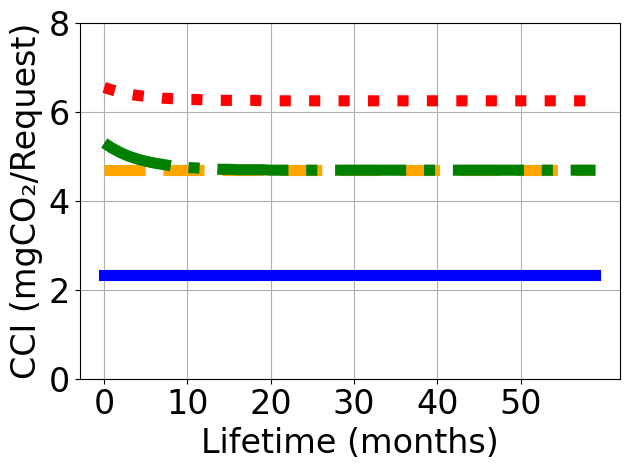

In [52]:
fs=24
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

plt.plot(np.arange(0, 60), np.full(60, 2.34), color='blue', ls='-', linewidth=8, label='EbbRT-Node1')
plt.plot(np.arange(0, 60), np.full(60, 4.69), color='orange', ls='--', linewidth=8, label='Linux-Node1')

arry=[]
CM = 152900
for i in range(0, 60):
    CM = CM - (CM/5)
    CI = 277300/998280000.0 # mg CO2/J
    CC = CI * 102.14
    CN = CI * (1250000000) * 2.7
    ops = 200000
    CCI = (CM/ops) + ((CC+CN)/ops)
    arry.append(round(CCI, 2))
plt.plot(np.arange(0, len(arry)), arry, color='green', ls='-.', linewidth=8, label='Linux-Node2')
    
#plt.axhline(y = 1.09, color='green', linestyle = '-.', linewidth=8, label='Linux-Node2') 
#plt.axhline(y = 2.48, color='red', linestyle = ':', linewidth=8, label='Linux-Node3') 

arry=[]
CM = 221900
for i in range(0, 60):
    CM = CM - (CM/5)
    CI = 277300/998280000.0 # mg CO2/J
    CC = CI * 269.32
    CN = CI * (5000000000) * 2.7
    ops = 600000
    arry.append(round((CM + (CC+CN))/ops, 2))
plt.plot(np.arange(0, len(arry)), arry, color='red', ls=':', linewidth=8, label='Linux-Node3')

"""
plt.axhline(y = 2.34, color='blue', linestyle = '-', linewidth=8, label='EbbRT-Node1') 
plt.axhline(y = 4.69, color='orange', linestyle = '--', linewidth=8, label='Linux-Node1') 
plt.axhline(y = 5.45, color='green', linestyle = '-.', linewidth=8, label='Linux-Node2') 
plt.axhline(y = 6.62, color='red', linestyle = ':', linewidth=8, label='Linux-Node3') 

"""
plt.xlabel("Lifetime (months)", fontsize=fs)
plt.ylabel("CCI (mgCO\u2082/Request)",  fontsize=fs)
plt.xticks(np.arange(0, 60, step=10))
plt.yticks(np.arange(0, 11, step=2))
plt.grid()
#plt.legend(ncol=2, fontsize=17, loc="upper left")
plt.ylim(bottom=0, top=8)
plt.tight_layout()
plt.savefig("silo_cci.pdf")
